## Load the data and simple visualisation

In [1]:
from load_oxford_flowers102 import load_oxford_flowers102
import show_methods
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import gzip
import pickle
import nets
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import plot_model

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
train_data, validation_data, test_data, class_names = load_oxford_flowers102(imsize=96, fine=False)
y_train = train_data["labels"]
y_test = test_data["labels"]
x_train = train_data["images"]
x_test = test_data["images"]
x_valid = validation_data["images"]
y_valid = validation_data["labels"]
# SEED = 1
input_shape = (96, 96, 3)
n_classes = len(class_names)

2024-04-09 15:45:11.483189: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-09 15:45:11.507184: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-09 15:45:11.927815: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqd

In [2]:
def class_proportions(labels, n_classes):
    # Create a dictionary with labels as keys and proportions as values
    proportions = np.zeros(n_classes)
    
    ## Count the number of examples of each class
    for label in labels:
        proportions[label] += 1

    return {label: proportion for label, proportion in enumerate(proportions)}


def balanced_accuracy(test_labels, predictions, outputs, name="balanced accuracy"):    
    # https://github.com/rois-codh/kmnist/pull/14/files/2b063db29fc7aa784a60ba69e13f72db892bf435
    totals = []
    for cls in range(outputs):
        total = 0
        for i in test_labels:
            if i == cls:
                total = total + 1
        totals.append(total)

    hits = []
    for cls in range(outputs):
        total_hits = 0
        for i in range(0, test_labels.shape[0]):
            if test_labels[i] == cls == np.argmax(predictions[i]):
                total_hits = total_hits + 1
        hits.append(total_hits)

    accuracy_list = []
    for i in range(0, len(hits)):
        accuracy = hits[i] / totals[i]
        accuracy_list.append(accuracy)

    return np.mean(accuracy_list)



In [3]:

def eval_net(net, epochs=50, load_from_file=False, net_name="net", summary=False, verbose=1, show_train_graph=False, data_aug=False,show_predictions=False):
    save_name = os.path.join('saved', f'{net_name}')
    net_save_name = save_name + '_cnn_net.h5'
    checkpoint_save_name = save_name + '_cnn_net.chk.weights.h5'
    history_save_name = save_name + '_cnn_net.hist'

    if load_from_file and os.path.isfile(net_save_name):
      net = tf.keras.models.load_model(net_save_name)
      with gzip.open(history_save_name) as f:
         history = pickle.load(f)
    else:           
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_save_name,
            save_weights_only=True,
            monitor='val_accuracy',
            mode='max',
            save_best_only=True)
        if data_aug:
            datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                zca_epsilon=1e-06,
                width_shift_range=0.1,
                height_shift_range=0.1,
                fill_mode='nearest',
                horizontal_flip=True
            )
            datagen.fit(x_train)

            train_data_aug = datagen.flow(x_train, y_train)

            train_info = net.fit(train_data_aug,
                                 validation_data=(x_valid, y_valid),
                                 epochs=epochs, shuffle=True,
                                 callbacks=[model_checkpoint_callback],
                                 verbose=verbose)
        else:
            train_info = net.fit(x_train, y_train, 
                                 validation_data=(x_valid, y_valid),
                                 epochs=epochs, shuffle=True,
                                 callbacks=[model_checkpoint_callback],
                                 verbose=verbose)
        net.save(net_save_name)
        history = train_info.history
        with gzip.open(history_save_name, 'w') as f:
            pickle.dump(history, f)

    if summary:
        net.summary()

    # Compute output for 16 test images
    y_test_pred = net.predict(x_test)
    y_train_pred = net.predict(x_train)

    loss_train, accuracy_train,  = net.evaluate(x_train, y_train, verbose=0)
    loss_test, accuracy_test = net.evaluate(x_test, y_test, verbose=0)

    bacc_test = balanced_accuracy(y_test, y_test_pred, n_classes)
    bacc_train = balanced_accuracy(y_train, y_train_pred, n_classes)

    print("Train accuracy (tf): %.2f" % accuracy_train)
    print("Test accuracy  (tf): %.2f" % accuracy_test)
    print("Train balanced accuracy (tf): %.2f" % bacc_train)
    print("Test balanced accuracy  (tf): %.2f" % bacc_test)


    if show_train_graph:
        #Plot training and validation accuracy over the course of training
        fh = plt.figure()
        ph = fh.add_subplot(111)
        ph.plot(history['accuracy'], label='accuracy')
        ph.plot(history['val_accuracy'], label = 'val_accuracy')
        ph.set_xlabel('Epoch')
        ph.set_ylabel('Accuracy')
        ph.set_ylim([0, 1])
        ph.legend(loc='lower right')
        plt.show()
        
    if show_predictions:
        show_methods.show_data_images(images=x_test[:16],
                            labels=y_test[:16],predictions= np.argmax(y_test_pred, axis=1),
                            class_names=class_names)

## Input Independent Baseline Model

In [11]:
n_samples = len(y_train)
x_baseline = np.zeros((n_samples, 96, 96, 3))
y_baseline = y_train

model = nets.simple_cnn(input_shape, n_classes)

model.fit(x_baseline, y_baseline, epochs=20)

y_test_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)

loss_train, accuracy_train,  = model.evaluate(x_train, y_train, verbose=0)
loss_test, accuracy_test = model.evaluate(x_test, y_test, verbose=0)

bacc_test = balanced_accuracy(y_test, y_test_pred, n_classes)
bacc_train = balanced_accuracy(y_train, y_train_pred, n_classes)

print("Train accuracy (tf): %.2f" % accuracy_train)
print("Test accuracy  (tf): %.2f" % accuracy_test)
print("Train balanced accuracy (tf): %.2f" % bacc_train)
print("Test balanced accuracy  (tf): %.2f" % bacc_test)

/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
2024-04-08 14:25:17.847038: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-08 14:25:17.867997: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-08 14:25:17.

Epoch 1/20


I0000 00:00:1712543118.848875   38526 service.cc:145] XLA service 0x70db5400b440 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1712543118.848903   38526 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2024-04-08 14:25:18.861286: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-08 14:25:18.922539: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


40/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1576 - loss: 2.2990

I0000 00:00:1712543119.858227   38526 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.1625 - loss: 2.2975
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1893 - loss: 2.2790
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2066 - loss: 2.2611
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1964 - loss: 2.2483
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2068 - loss: 2.2276
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2033 - loss: 2.2238
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2018 - loss: 2.2116
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2037 - loss: 2.2017
Epoch 9/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2023 - loss: 2.1928
Epoch 10/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2062 - loss: 2.1807
Epoch 11/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2046 - loss: 2.1740
Epoch 12/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2121 - loss: 2.1734

## Very Simple CNN

In [112]:
simple_cnn = tf.keras.models.Sequential()
simple_cnn.add(Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=input_shape))
simple_cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
simple_cnn.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding='same'))
simple_cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
simple_cnn.add(Flatten())
simple_cnn.add(Dense(units=32, activation='relu'))
simple_cnn.add(Dense(units=n_classes, activation='softmax'))

simple_cnn.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

simple_cnn.summary()


Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_194 (Conv2D)             │ (None, 96, 96, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_109               │ (None, 48, 48, 16)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_195 (Conv2D)             │ (None, 24, 24, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_110               │ (None, 12, 12, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_32 (Flatten)            │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_107 (Dense)               │ (None, 32)             │       147,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_108 (Dense)               │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 152,906 (597.29 KB)

 Trainable params: 152,906 (597.29 KB)

 Non-trainable params: 0 (0.00 B)

In [113]:
eval_net(simple_cnn, 100, load_from_file=False, net_name="simple_cnn", summary=False, verbose=False)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Train accuracy (tf): 0.21
Test accuracy  (tf): 0.22
Train balanced accuracy (tf): 0.10
Test balanced accuracy  (tf): 0.10


I started with the cnn created in example3.py and reduced the number of filters, dense layers, units in the dense layer, and number of convolutions. to the find model with the least number of parameters that could fit the training data. this the smallest model i found was 150,000 parameters. with this model it achieved 98% train balanced accuracy but only 34% test balanced accuracy. 

After re-training this model several times it appears to be very unstable. sometimes is doesn't learn anything at all. however sometimes it fully fits the training data

We are allowed a model with 15 million parameters.

First I will add data augmentation to the simple model

In [114]:
eval_net(simple_cnn, 100, load_from_file=True, net_name="simple_cnn_aug", summary=False, verbose=False, data_aug=True)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Train accuracy (tf): 0.21
Test accuracy  (tf): 0.22
Train balanced accuracy (tf): 0.10
Test balanced accuracy  (tf): 0.10


Just adding data augmentation increased the test balanced accuracy to 65%. After 100 epochs the train and val accuracy are still slowing improving.

However the model is unstable.

i will make a model with ~5 million parameters and see what it does

In [115]:
medium_cnn_reg = tf.keras.models.Sequential()
medium_cnn_reg.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=input_shape))
medium_cnn_reg.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
medium_cnn_reg.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same'))
medium_cnn_reg.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
medium_cnn_reg.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding='same'))
medium_cnn_reg.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
medium_cnn_reg.add(Flatten())
medium_cnn_reg.add(Dense(units=512, activation='relu'))
medium_cnn_reg.add(Dense(units=128, activation='relu'))
medium_cnn_reg.add(Dense(units=n_classes, activation='softmax'))

medium_cnn_reg.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
medium_cnn_reg.save_weights('medium_cnn_model.weights.h5')
medium_cnn_reg.summary()


Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_196 (Conv2D)             │ (None, 96, 96, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_111               │ (None, 48, 48, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_197 (Conv2D)             │ (None, 48, 48, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_112               │ (None, 24, 24, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_198 (Conv2D)             │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_113               │ (None, 6, 6, 256)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_33 (Flatten)            │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_109 (Dense)               │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_110 (Dense)               │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_111 (Dense)               │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,156,874 (19.67 MB)

 Trainable params: 5,156,874 (19.67 MB)

 Non-trainable params: 0 (0.00 B)

First with no data augmentation

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Train accuracy (tf): 1.00
Test accuracy  (tf): 0.62
Train balanced accuracy (tf): 1.00
Test balanced accuracy  (tf): 0.58


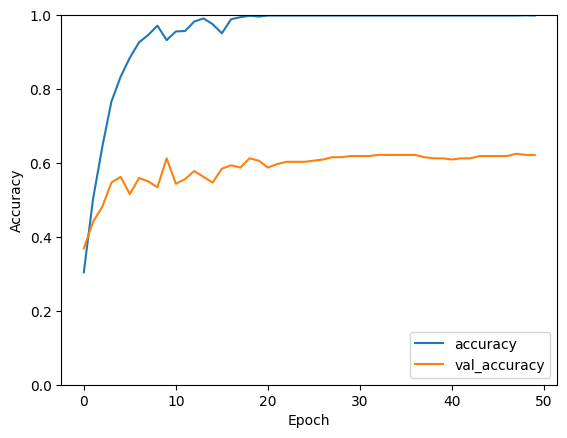

In [116]:
medium_cnn_reg.load_weights('medium_cnn_model.weights.h5')
eval_net(medium_cnn_reg, 50, load_from_file=True, net_name="med_cnn", show_train_graph=True)

The model is clearly overfitting very early. maybe adding data augmentation will reduce this issue

Epoch 1/50


/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.2111 - loss: 21.1957 - val_accuracy: 0.4219 - val_loss: 1.6215
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4348 - loss: 1.5709 - val_accuracy: 0.4156 - val_loss: 1.7658
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5057 - loss: 1.4019 - val_accuracy: 0.4969 - val_loss: 1.4835
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6080 - loss: 1.1058 - val_accuracy: 0.4875 - val_loss: 1.4733
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5988 - loss: 1.1311 - val_accuracy: 0.5906 - val_loss: 1.3238
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6359 - loss: 1.0085 - val_accuracy: 0.5969 - val_loss: 1.1549
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6802 - loss: 0.9151 - val_accuracy: 0.6062 - val_loss: 1.2112
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6849 - loss: 0.8516 - val_accuracy: 0.5312 - val_loss: 1

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Train accuracy (tf): 0.95
Test accuracy  (tf): 0.73
Train balanced accuracy (tf): 0.92
Test balanced accuracy  (tf): 0.67


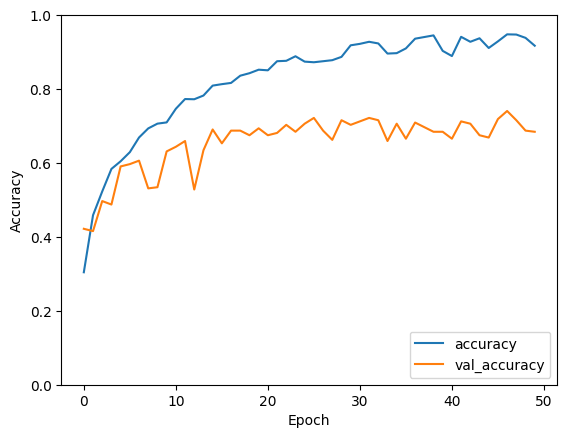

In [117]:
medium_cnn_reg.load_weights('medium_cnn_model.weights.h5')
eval_net(medium_cnn_reg, 50, load_from_file=False, net_name="med_cnn_aug", show_train_graph=True, data_aug=True, verbose=True)


seems to reduce overfitting for sure. after training balanced test accuracy was ~70%, and the train accuracy was still improving, but val accuracy stabilised. maybe increase learning rate

/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 26 variables whereas the saved optimizer has 2 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.1609 - loss: 165.2491 - val_accuracy: 0.2281 - val_loss: 2.3335
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.2326 - loss: 2.1381 - val_accuracy: 0.2344 - val_loss: 2.1806
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.2125 - loss: 2.1369 - val_accuracy: 0.2250 - val_loss: 2.2354
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.2260 - loss: 2.1028 - val_accuracy: 0.2250 - val_loss: 2.2661
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.2210 - loss: 2.1156 - val_accuracy: 0.2219 - val_loss: 2.2872
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.2067 - loss: 2.1424 - val_accuracy: 0.2219 - val_loss: 2.2526
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.2037 - loss: 2.1239 - val_accuracy: 0.2219 - val_loss: 2.3016
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.2130 - loss: 2.1137 - val_accuracy: 0.2188 -

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Train accuracy (tf): 0.40
Test accuracy  (tf): 0.31
Train balanced accuracy (tf): 0.30
Test balanced accuracy  (tf): 0.25


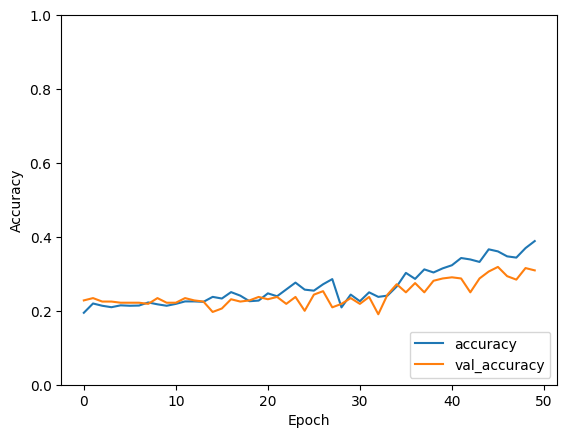

In [118]:

medium_cnn_reg.load_weights('medium_cnn_model.weights.h5')
medium_cnn_reg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
eval_net(medium_cnn_reg, 50, load_from_file=False, net_name="med_cnn_aug_005", show_train_graph=True, data_aug=True, verbose=True)

Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.3915 - loss: 1.7311 - val_accuracy: 0.3750 - val_loss: 1.8463
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4296 - loss: 1.6108 - val_accuracy: 0.3688 - val_loss: 1.8794
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4234 - loss: 1.5807 - val_accuracy: 0.3750 - val_loss: 1.8598
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4556 - loss: 1.5704 - val_accuracy: 0.3750 - val_loss: 1.8477
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4706 - loss: 1.5045 - val_accuracy: 0.3469 - val_loss: 1.9690
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4951 - loss: 1.4188 - val_accuracy: 0.3719 - val_loss: 1.8476
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4953 - loss: 1.4141 - val_accuracy: 0.3812 - val_loss: 1.8085
Epoch 8/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4870 - loss: 1.4182 - val_accuracy: 0.4000 - v

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Train accuracy (tf): 0.77
Test accuracy  (tf): 0.50
Train balanced accuracy (tf): 0.73
Test balanced accuracy  (tf): 0.48


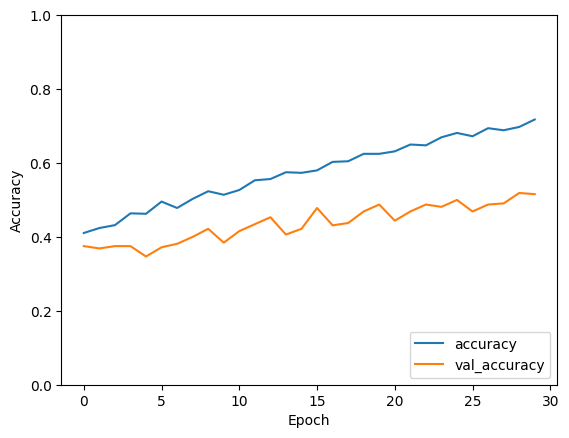

In [119]:
medium_cnn_reg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
eval_net(medium_cnn_reg, 30, load_from_file=False, net_name="med_cnn_aug_005", show_train_graph=True, data_aug=True, verbose=True)

good idea to start with 005 learning rate and increase to 001. If i keep training and turn off data aug, will the model overfit?

Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7604 - loss: 0.6620 - val_accuracy: 0.4969 - val_loss: 1.8725
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8713 - loss: 0.4161 - val_accuracy: 0.5156 - val_loss: 1.9487
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9234 - loss: 0.2635 - val_accuracy: 0.4875 - val_loss: 2.3359
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9635 - loss: 0.1553 - val_accuracy: 0.5063 - val_loss: 2.5717
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9890 - loss: 0.0849 - val_accuracy: 0.5156 - val_loss: 2.8599
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9947 - loss: 0.0435 - val_accuracy: 0.5125 - val_loss: 3.1357
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9995 - loss: 0.0175 - val_accuracy: 0.5219 - val_loss: 3.4706
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9982 - loss: 0.0141 - val_accuracy: 0.5094 - val_loss

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
Train accuracy (tf): 1.00
Test accuracy  (tf): 0.50
Train balanced accuracy (tf): 1.00
Test balanced accuracy  (tf): 0.45


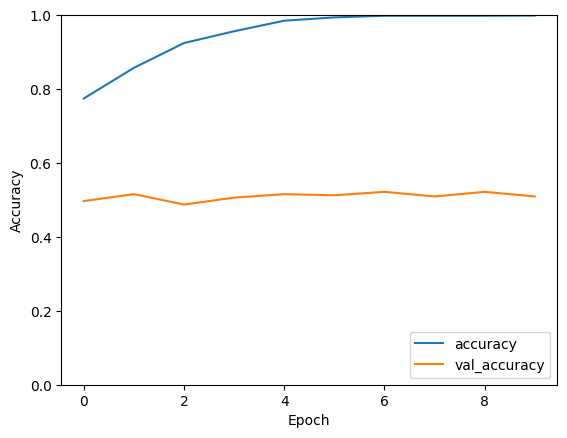

In [120]:
eval_net(medium_cnn_reg, 10, load_from_file=False, net_name="med_cnn_aug_005", show_train_graph=True, data_aug=False, verbose=True)

Yet it does over fit. so the only reason the model isn't overfitting is because of data aug. i think it will be good to add some other regularisation. starting with batch normalisation

In [14]:
def medium_cnn_reg():
    medium_cnn_reg = tf.keras.models.Sequential()
    medium_cnn_reg.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(96,96,3)))
    medium_cnn_reg.add(BatchNormalization())
    medium_cnn_reg.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    medium_cnn_reg.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same'))
    medium_cnn_reg.add(BatchNormalization())
    medium_cnn_reg.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    medium_cnn_reg.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding='same'))
    medium_cnn_reg.add(BatchNormalization())
    medium_cnn_reg.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    medium_cnn_reg.add(Flatten())
    medium_cnn_reg.add(Dense(units=512, activation='relu'))
    medium_cnn_reg.add(Dense(units=128, activation='relu'))
    medium_cnn_reg.add(Dense(units=n_classes, activation='softmax'))

    medium_cnn_reg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    medium_cnn_reg.summary()
    
    return medium_cnn_reg
net = medium_cnn_reg()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 96, 96, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96, 96, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 48, 48, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,158,666 (19.68 MB)

 Trainable params: 5,157,770 (19.68 MB)

 Non-trainable params: 896 (3.50 KB)

In [15]:
net = medium_cnn_reg()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 96, 96, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 96, 96, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 48, 48, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 48, 48, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,158,666 (19.68 MB)

 Trainable params: 5,157,770 (19.68 MB)

 Non-trainable params: 896 (3.50 KB)

/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_68 (Conv2D)              │ (None, 96, 96, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 96, 96, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_69 (Conv2D)              │ (None, 48, 48, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 48, 48, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_70 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,158,666 (19.68 MB)

 Trainable params: 5,157,770 (19.68 MB)

 Non-trainable params: 896 (3.50 KB)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Train accuracy (tf): 0.95
Test accuracy  (tf): 0.54
Train balanced accuracy (tf): 0.96
Test balanced accuracy  (tf): 0.50


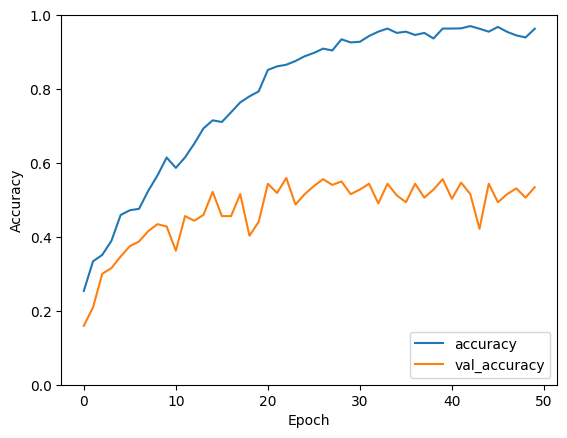

In [ ]:
net = medium_cnn_reg()
eval_net(net, epochs=50, load_from_file=True, net_name="med_cnn_aug_reg", show_train_graph=True, data_aug=True, verbose=True)

With batch normalisation, and no data augmentation. it doesn't reach 100% train accuracy after 50 epochs. but val accuracy doesn't improve much after ~ 15 epochs

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_71 (Conv2D)              │ (None, 96, 96, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 96, 96, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_51 (MaxPooling2D) │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_72 (Conv2D)              │ (None, 48, 48, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 48, 48, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_52 (MaxPooling2D) │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_73 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_53 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,158,666 (19.68 MB)

 Trainable params: 5,157,770 (19.68 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/50


/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.2303 - loss: 10.2096 - val_accuracy: 0.0906 - val_loss: 3.1117
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.2675 - loss: 2.0700 - val_accuracy: 0.1625 - val_loss: 2.1352
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3346 - loss: 1.9461 - val_accuracy: 0.2344 - val_loss: 2.1136
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3752 - loss: 1.8573 - val_accuracy: 0.2937 - val_loss: 2.0523
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3766 - loss: 1.8059 - val_accuracy: 0.3250 - val_loss: 2.4021
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.4183 - loss: 1.7412 - val_accuracy: 0.3344 - val_loss: 2.0326
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4355 - loss: 1.6477 - val_accuracy: 0.3469 - val_loss: 2.0461
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4474 - loss: 1.5925 - val_accuracy: 0.3344 - val_loss: 1

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Train accuracy (tf): 0.89
Test accuracy  (tf): 0.67
Train balanced accuracy (tf): 0.91
Test balanced accuracy  (tf): 0.65


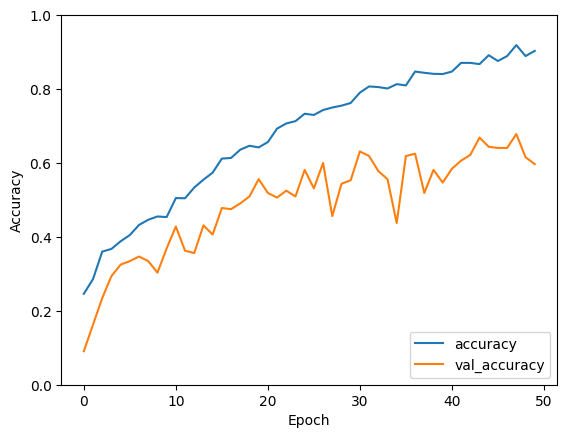

In [ ]:
net = medium_cnn_reg()
eval_net(net, epochs=50, load_from_file=False, net_name="med_cnn_aug_reg", summary=False,show_train_graph=True, data_aug=True, verbose=True)

looks good still going up. i will keep training with smaller learning rate

Epoch 1/30


/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9319 - loss: 0.2083 - val_accuracy: 0.6844 - val_loss: 1.4376
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9576 - loss: 0.1446 - val_accuracy: 0.7031 - val_loss: 1.5168
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9500 - loss: 0.1368 - val_accuracy: 0.6906 - val_loss: 1.5260
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9737 - loss: 0.0893 - val_accuracy: 0.6562 - val_loss: 1.9020
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9683 - loss: 0.0925 - val_accuracy: 0.6875 - val_loss: 1.7838
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9657 - loss: 0.0908 - val_accuracy: 0.6781 - val_loss: 1.8802
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9700 - loss: 0.0816 - val_accuracy: 0.7063 - val_loss: 1.8030
Epoch 8/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9689 - loss: 0.0942 - val_accuracy: 0.6969 - val_loss: 1.

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Train accuracy (tf): 1.00
Test accuracy  (tf): 0.73
Train balanced accuracy (tf): 0.99
Test balanced accuracy  (tf): 0.70


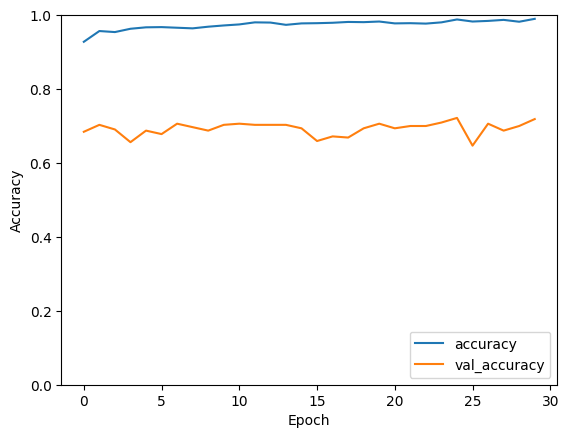

In [ ]:
net.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
eval_net(net, epochs=30, load_from_file=False, net_name="med_cnn_aug_reg", summary=False,show_train_graph=True, data_aug=True, verbose=True)

seems to be very stuck at 70% val accuracy.

I think i need to increase the size of the model

# Large cnn

In [6]:
def large_cnn():
    large_cnn = tf.keras.models.Sequential()
    large_cnn.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(96,96,3)))
    large_cnn.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(96,96,3)))
    large_cnn.add(BatchNormalization())
    large_cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    large_cnn.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same'))
    large_cnn.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same'))
    large_cnn.add(BatchNormalization())
    large_cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    large_cnn.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same'))
    large_cnn.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same'))
    large_cnn.add(BatchNormalization())
    large_cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    large_cnn.add(Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same'))
    large_cnn.add(Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same'))
    large_cnn.add(BatchNormalization())
    large_cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    large_cnn.add(Flatten())
    large_cnn.add(Dense(units=512, activation='relu'))
    large_cnn.add(Dense(units=512, activation='relu'))
    large_cnn.add(Dense(units=128, activation='relu'))
    large_cnn.add(Dense(units=n_classes, activation='softmax'))

    large_cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    large_cnn.summary()
    
    return large_cnn
net_large = large_cnn()


2024-04-09 15:49:35.393013: W external/local_tsl/tsl/framework/bfc_allocator.cc:487] Allocator (GPU_0_bfc) ran out of memory trying to allocate 9.00MiB (rounded to 9437184)requested by op Mul
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-04-09 15:49:35.393083: I external/local_tsl/tsl/framework/bfc_allocator.cc:1044] BFCAllocator dump for GPU_0_bfc
2024-04-09 15:49:35.393109: I external/local_tsl/tsl/framework/bfc_allocator.cc:1051] Bin (256): 	Total Chunks: 48, Chunks in use: 48. 12.0KiB allocated for chunks. 12.0KiB in use in bin. 4.7KiB client-requested in use in bin.
2024-04-09 15:49:35.393132: I external/local_tsl/tsl/framework/bfc_allocator.cc:1051] Bin (512): 	Total Chunks: 18, Chunks in use: 18. 9.0KiB allocated for chunks. 9.0KiB in use in bin. 9.0KiB client-requested in use in bin.
2024-04-09 15:49:35.393149: I ex

ResourceExhaustedError: {{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:Mul] name: 

The number of parameters depends largely upon the first dense layer and the last convolutional layer.

what is the ideal shape of the data after the last convolution??

In [11]:
net_large.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
eval_net(net_large, epochs=50, load_from_file=False, net_name="lrg_cnn_aug_reg", summary=False,show_train_graph=True, data_aug=True, verbose=True)

NameError: name 'net' is not defined

keep training

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5247 - loss: 1.3002 - val_accuracy: 0.3812 - val_loss: 1.8140
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5601 - loss: 1.2414 - val_accuracy: 0.4219 - val_loss: 1.6704
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5483 - loss: 1.3203 - val_accuracy: 0.4281 - val_loss: 1.5520
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6023 - loss: 1.1807 - val_accuracy: 0.3781 - val_loss: 2.0099
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5717 - loss: 1.2583 - val_accuracy: 0.3375 - val_loss: 1.8116
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5421 - loss: 1.2779 - val_accuracy: 0.4500 - val_loss: 1.6978
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5768 - loss: 1.2158 - val_accuracy: 0.4313 - val_loss: 1.7816
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6433 - loss: 1.0475 - val_accuracy: 0.4156 - v

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Train accuracy (tf): 0.86
Test accuracy  (tf): 0.64
Train balanced accuracy (tf): 0.76
Test balanced accuracy  (tf): 0.59


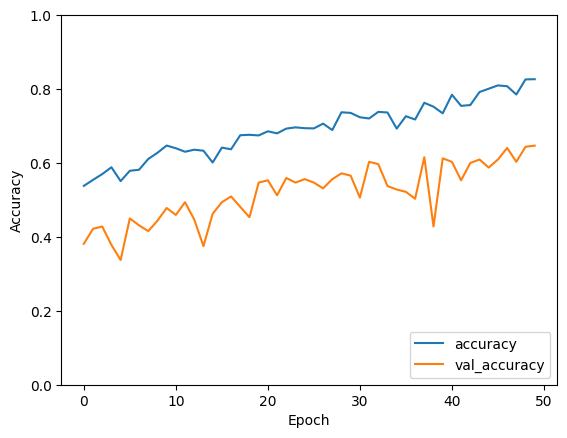

In [ ]:
eval_net(net, epochs=50, load_from_file=False, net_name="lrg_cnn_aug_reg", summary=False,show_train_graph=True, data_aug=True, verbose=True)


keep training

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8394 - loss: 0.5344 - val_accuracy: 0.6281 - val_loss: 1.4807
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8328 - loss: 0.5219 - val_accuracy: 0.6500 - val_loss: 1.4056
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8301 - loss: 0.5306 - val_accuracy: 0.5594 - val_loss: 1.5000
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8031 - loss: 0.6366 - val_accuracy: 0.5906 - val_loss: 1.9497
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8062 - loss: 0.5799 - val_accuracy: 0.6031 - val_loss: 1.7055
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8175 - loss: 0.5785 - val_accuracy: 0.6031 - val_loss: 2.0312
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8365 - loss: 0.5311 - val_accuracy: 0.6156 - val_loss: 1.9018
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8162 - loss: 0.5559 - val_accuracy: 0.6344 - v

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Train accuracy (tf): 0.92
Test accuracy  (tf): 0.69
Train balanced accuracy (tf): 0.83
Test balanced accuracy  (tf): 0.63


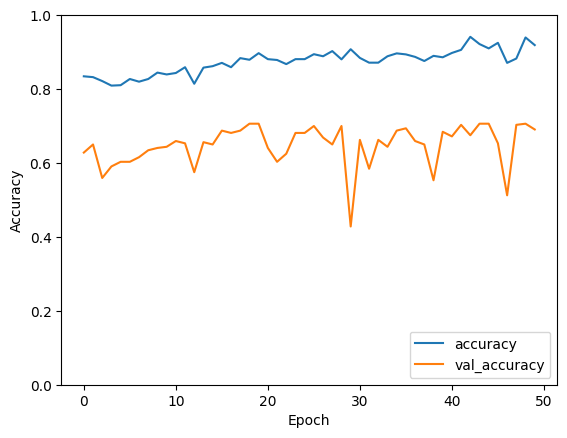

In [ ]:
eval_net(net, epochs=50, load_from_file=False, net_name="lrg_cnn_aug_reg", summary=False,show_train_graph=True, data_aug=True, verbose=True)


Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9078 - loss: 0.3287 - val_accuracy: 0.6094 - val_loss: 5.1815
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8745 - loss: 0.4247 - val_accuracy: 0.6531 - val_loss: 2.8652
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9202 - loss: 0.2660 - val_accuracy: 0.7156 - val_loss: 1.6400
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9279 - loss: 0.2776 - val_accuracy: 0.7031 - val_loss: 1.6855
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9284 - loss: 0.2432 - val_accuracy: 0.7000 - val_loss: 1.5090
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9394 - loss: 0.1759 - val_accuracy: 0.6938 - val_loss: 2.3199
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9483 - loss: 0.1999 - val_accuracy: 0.6938 - val_loss: 1.7260
Epoch 8/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9388 - loss: 0.2051 - val_accuracy: 0.6875 - v

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Train accuracy (tf): 0.84
Test accuracy  (tf): 0.55
Train balanced accuracy (tf): 0.76
Test balanced accuracy  (tf): 0.51


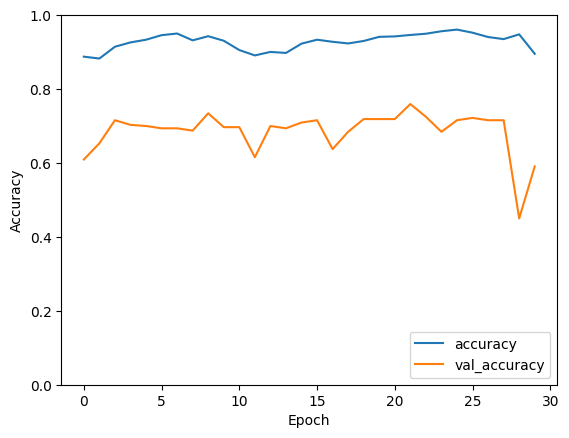

In [ ]:
net_large.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
eval_net(net, epochs=30, load_from_file=False, net_name="lrg_cnn_aug_reg", summary=False,show_train_graph=True, data_aug=True, verbose=True)


Epoch 1/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9805 - loss: 0.0678 - val_accuracy: 0.7469 - val_loss: 2.2709
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9804 - loss: 0.0682 - val_accuracy: 0.7469 - val_loss: 1.5930
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9792 - loss: 0.0669 - val_accuracy: 0.7406 - val_loss: 3.2056
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9849 - loss: 0.0780 - val_accuracy: 0.7125 - val_loss: 1.9875
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9490 - loss: 0.1665 - val_accuracy: 0.7250 - val_loss: 2.1751
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9589 - loss: 0.1523 - val_accuracy: 0.7500 - val_loss: 1.7436
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9728 - loss: 0.0783 - val_accuracy: 0.7563 - val_loss: 1.8850
Epoch 8/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9748 - loss: 0.0826 - val_accuracy: 0.

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Train accuracy (tf): 1.00
Test accuracy  (tf): 0.76
Train balanced accuracy (tf): 1.00
Test balanced accuracy  (tf): 0.73


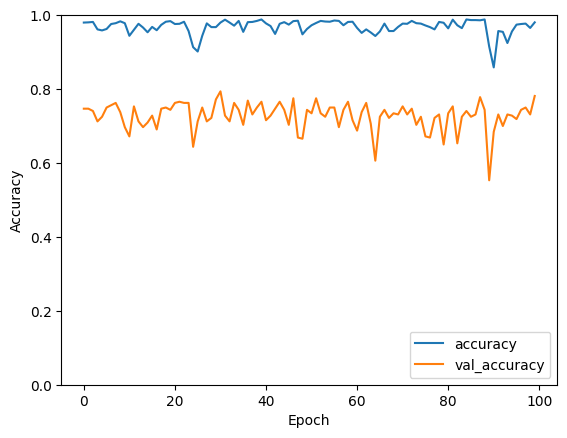

In [ ]:
net_large.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
eval_net(net, epochs=100, load_from_file=False, net_name="lrg_cnn_aug_reg", summary=False,show_train_graph=True, data_aug=True, verbose=True)
